In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import os
from load_img.baseimage import PETImage, normalize
from scipy.integrate import odeint
from kmeans_segmentation import pca_kmeans_segmentation, fourier_kmeans_segmentation, apply_masks, plot_segments
from utility_functions import sparsifyDynamics, poolData
from matplotlib import style
style.use('dark_background')

#### Some helpful functions

In [2]:
def disp_segment(seg, ax = None, view_ax = 'y', col_t = 'sum', col_v = 'sum', figsize=(18, 16)):
    ax_ix = {'z':0,'y':1,'x':2,'t':3}[view_ax]
    
    frame = getattr(seg,col_t)(axis=3)
    
    img = getattr(frame,col_v)(axis=ax_ix)
    
    if ax is None:
        fig = plt.figure(figsize=figsize)
        plt.imshow(img,cmap='gray')
        plt.show()
    else:
        ax.imshow(img,cmap='gray')
    

    
# def find_opt_x0(dynamic_fn, xdf):
    
    

    

#### Data from File

In [3]:
data_dir = 'data'
pet_files = [f for f in os.listdir(data_dir) if f.endswith('.pet.img') and not f.startswith('.')]
fname = pet_files[0]
fpath = os.path.join(data_dir,fname)
my_img = PETImage(filepath=fpath)
my_img.load_image()

File dimensions: (128,128,159,40)
Reading image data...


## Segment Image

#### Fourier Segmentation

In [4]:
# Ns = my_img.img_data.shape

# # select the middle z=Ws[0],y=Ws[1],x=Ws[2] prism of each frame
# Ws = (128,60,40)
# roi_lims = [(int((N-W)/2),int((N+W)/2)) for N,W in zip(Ns,Ws)]

# # select options for segmentation and run segmentation
# print('Clustering image voxels...')
# options = {
#     'roi_lims' : roi_lims,
#     'plot' : True,
#     'fig_size' : (18, 16),
#     'nfeatures' : 6,
#     'nclusters' : 20
#     }
# masks, roi = fourier_kmeans_segmentation(my_img,**options)



#### Time series segmentation

In [5]:
Ns = my_img.img_data.shape

# select the middle z=Ws[0],y=Ws[1],x=Ws[2] prism of each frame
Ws = (128,60,40)
roi_lims = [(int((N-W)/2),int((N+W)/2)) for N,W in zip(Ns,Ws)]

# select options for segmentation and run segmentation
print('Clustering image voxels...')
options = {
    'roi_lims' : roi_lims,
    'figsize' : (18, 16),
    'nfeatures' : 6,
    'nclusters' : 8
    }
masks, roi = pca_kmeans_segmentation(my_img,**options)

# done with original image data
my_img.unload_image()

Clustering image voxels...
Created 8 masks of image


#### apply masks to original ROI

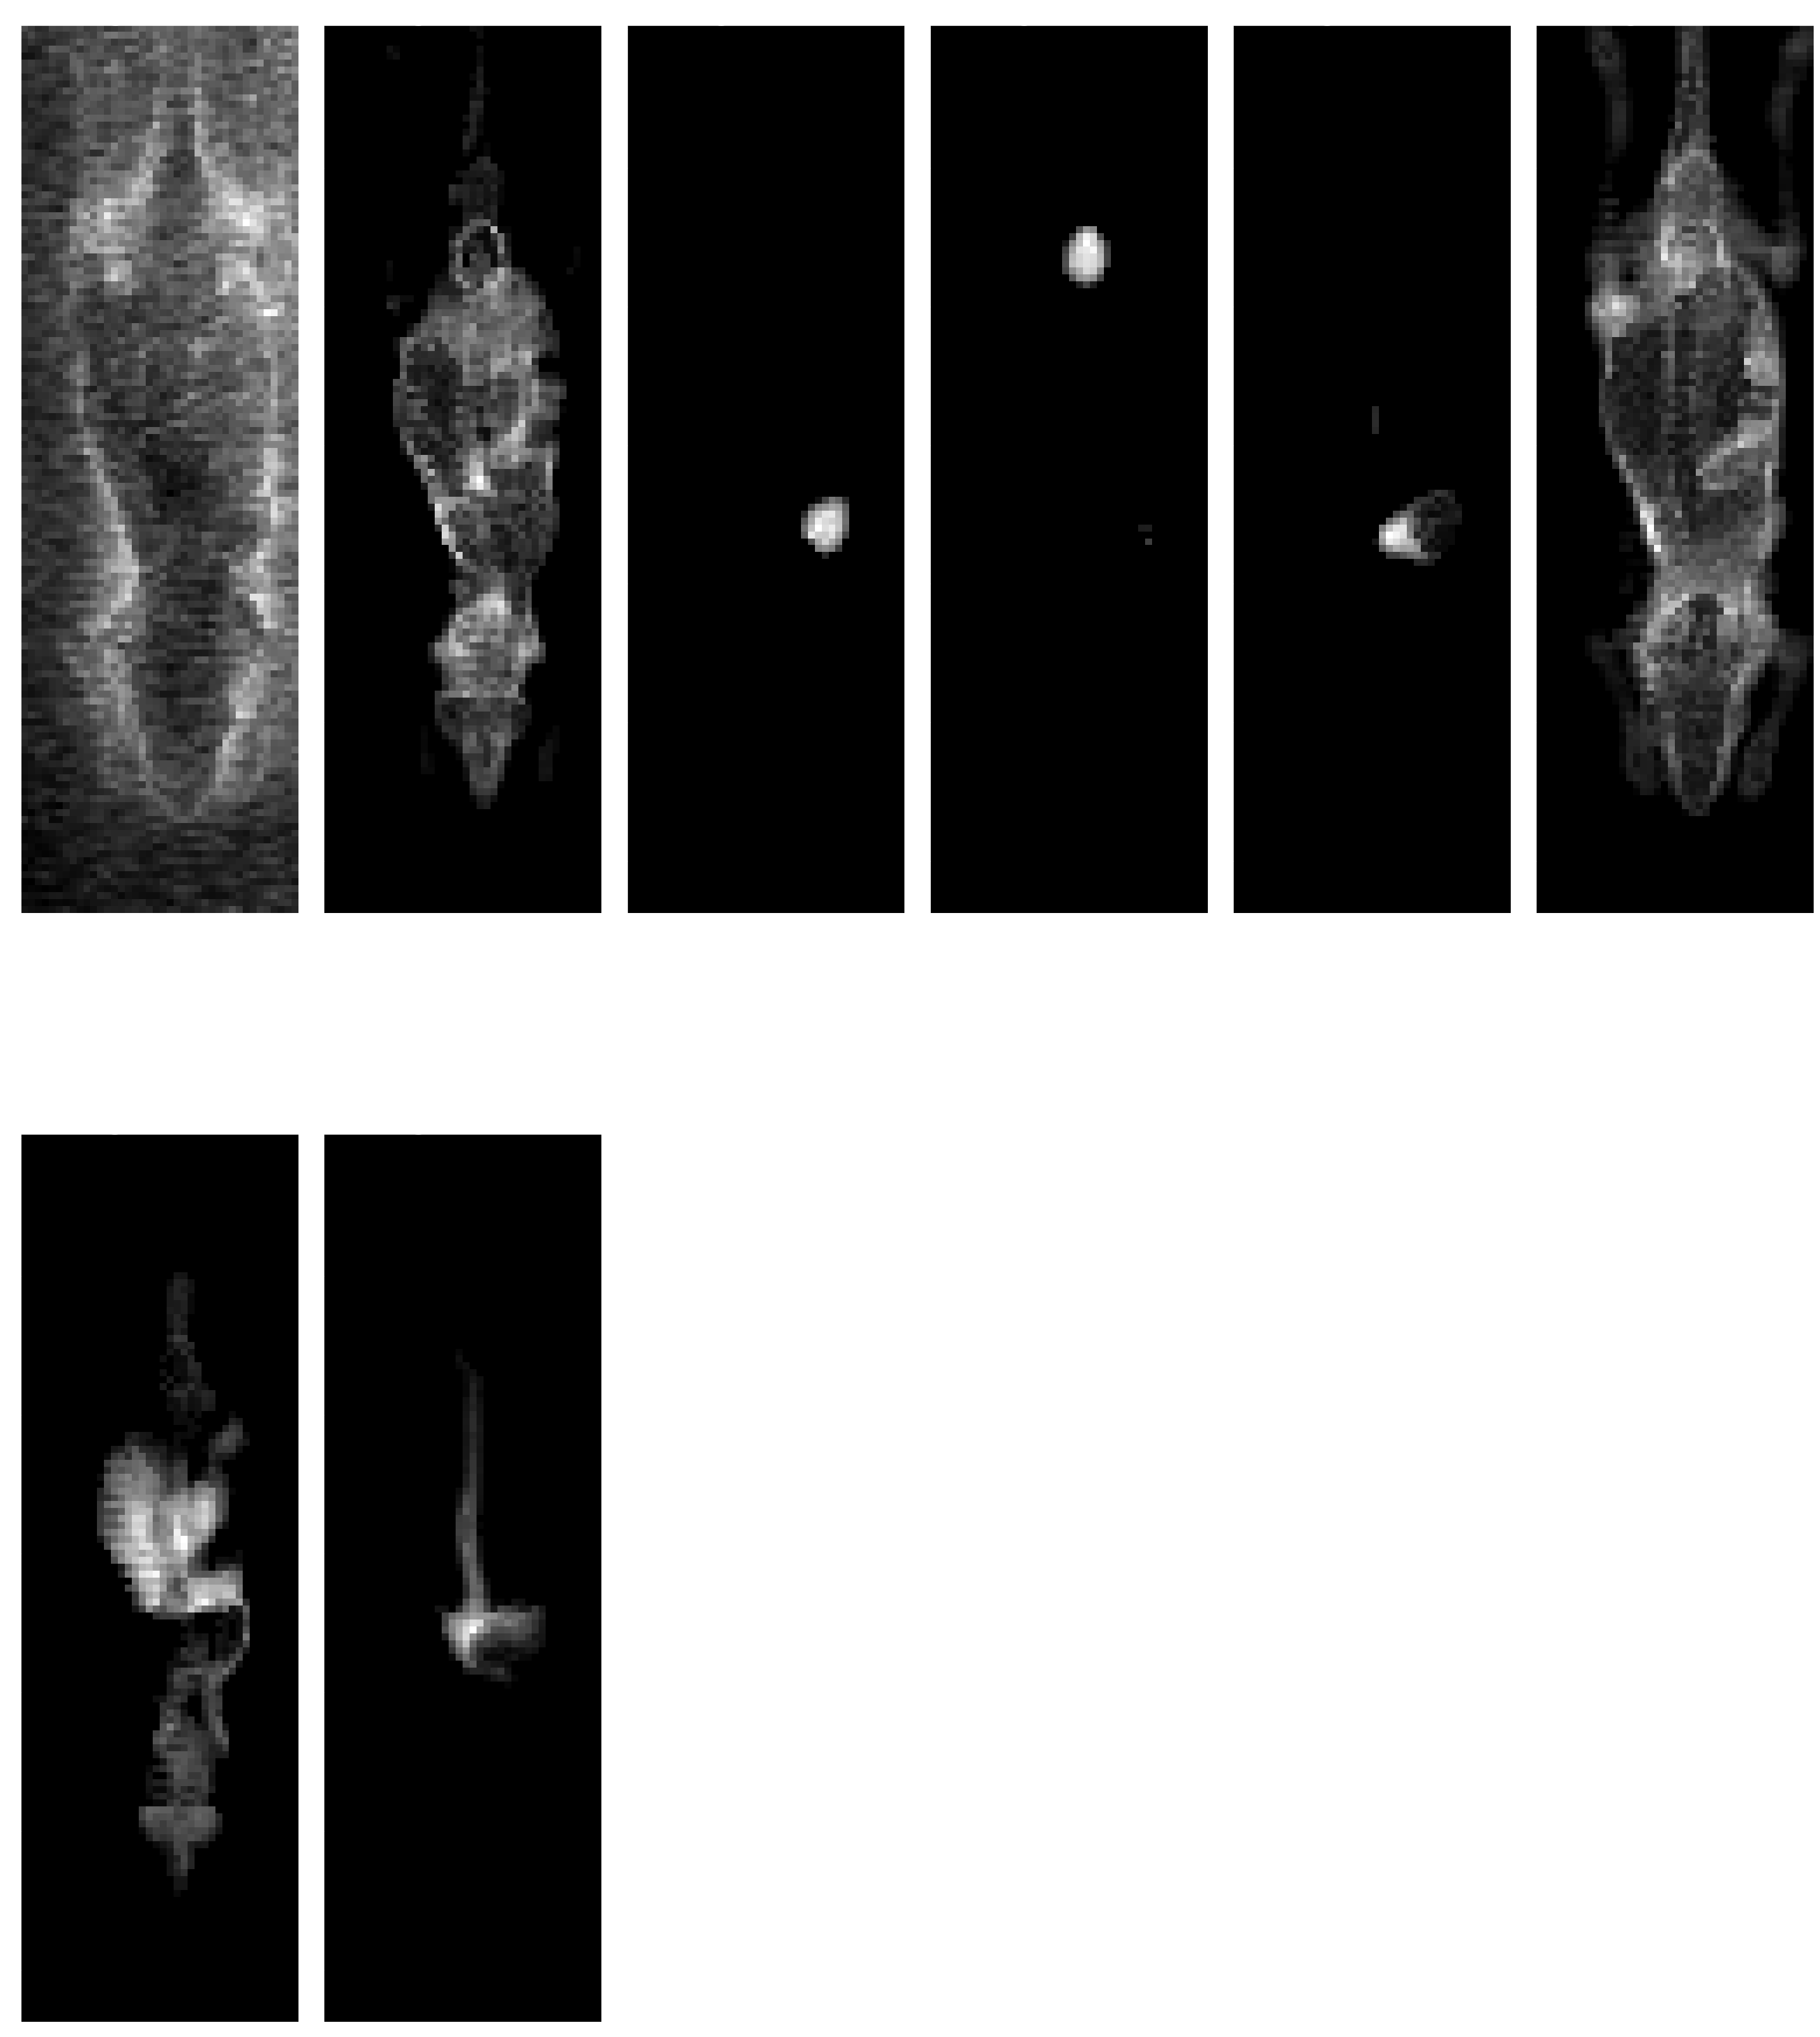

In [6]:
# done with original image data
my_img.unload_image()
new_rois = apply_masks(masks,roi)
plot_segments(new_rois)

#### plot total intensity of each segment

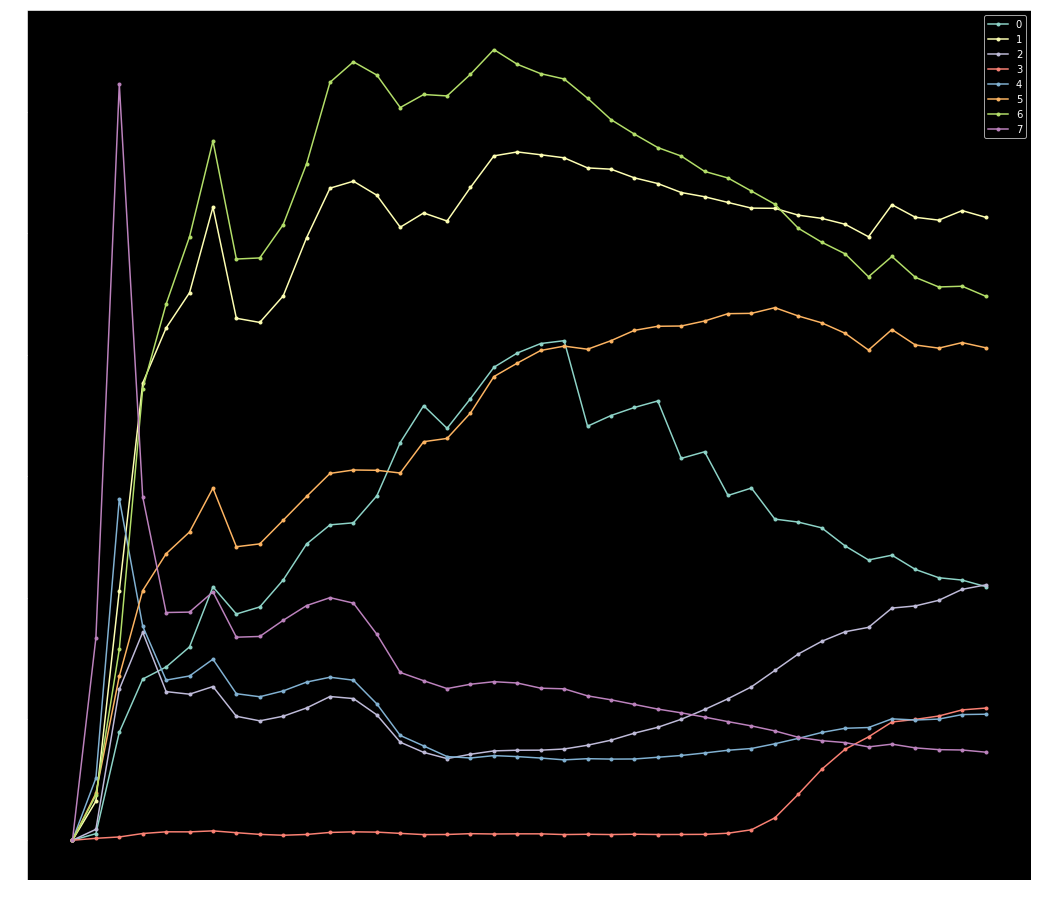

In [7]:
intensity_curves  = [mroi.reshape(Ws[0]*Ws[1]*Ws[2],Ns[-1]).sum(axis=0) for mroi in new_rois]
df = pd.DataFrame(data=np.stack(intensity_curves).T)
df.plot(figsize=(18, 16),marker='.')

#### Pick some clusters

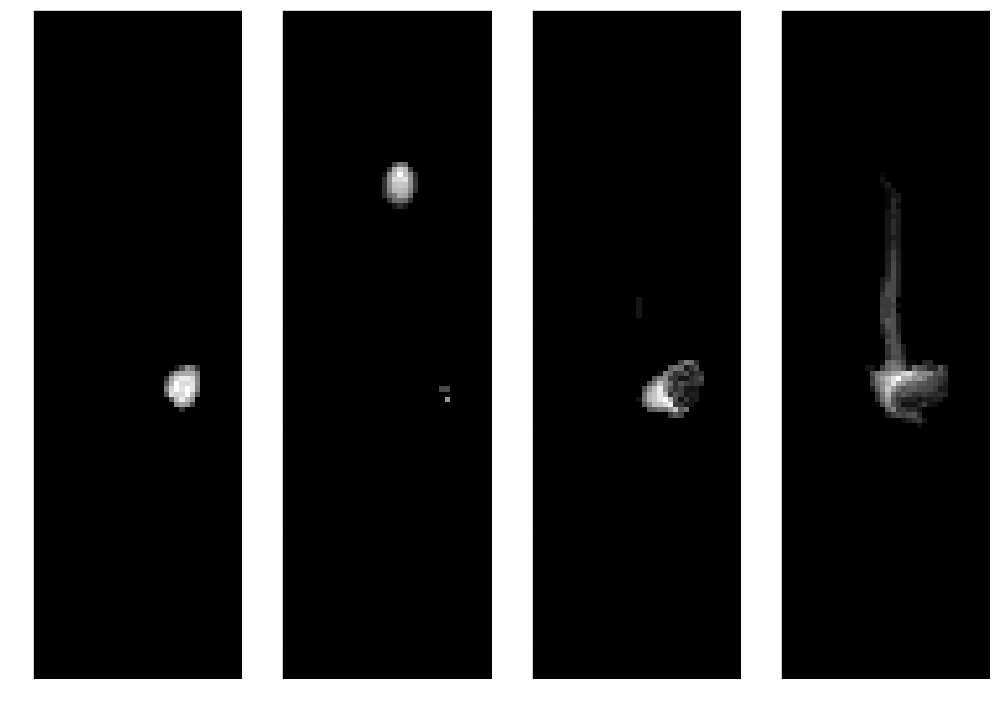

In [17]:
ixs = [2,3,4,7]
# ixs = list(range(1,options['nclusters']))
fig = plt.figure(figsize=(14,12))
axes = []
for k,ix in enumerate(ixs):
    ax = plt.subplot(1,len(ixs),k+1)
    axes.append(ax)
    disp_segment(new_rois[ix], ax=axes[-1],view_ax='y')
plt.tight_layout()
plt.show()


#### Get cluster data as df    

In [18]:
# since we lose a row in diff step,
# just use first N rows of df


# dont use first few rows with no tracer
N = 40
n_start = 3
npts = N-n_start-1
X = df[n_start:-1]
X_dot = df.diff()[n_start+1:]

#### Get subdf with just the ixs of the clusters we want to analyze

In [19]:
tX = X[ixs].reset_index(drop=True)
tX_dot = X_dot[ixs].reset_index(drop=True)
frame_durations = my_img.params.frame_duration[n_start:-1]
tX_dot = tX_dot.div(frame_durations,axis=0)   # divide out frame duration
tX.shape

(36, 4)

#### Run SINDy

In [20]:
n,nVars = tX.shape

# variable labeling
cols = ['x{}'.format(i+1) for i in range(nVars)]
tX.columns = cols
dot_labels = pd.Index([s + 'dot' for s in cols])

# SINDy params
polyorder = 1
lam = 0.001
usesine = 0

# generate data
Theta = pd.DataFrame()
Theta = poolData(tX,nVars, polyorder, usesine)

# run SINDy
Xhat_df = sparsifyDynamics(Theta,tX_dot,lam)
Xhat_df = Xhat_df.set_index(dot_labels)
print(Xhat_df.head())

## Test recovered dynamics

In [22]:
# find dynamic_fn: x -> x_dot
dynamic_fn = lambda x,t: np.squeeze(np.matmul(
        Xhat_df.as_matrix(),
        poolData(pd.DataFrame(x).T,nVars, polyorder, usesine).values.T
))

# times at which to evaluate solution
t_span = np.cumsum(frame_durations)

# how to choose x0?
x0 = tX.iloc[0].values

# reconstruct x(t_span)
X_s = odeint(dynamic_fn,x0,t_span)

###### Plot phase curves for simulated 

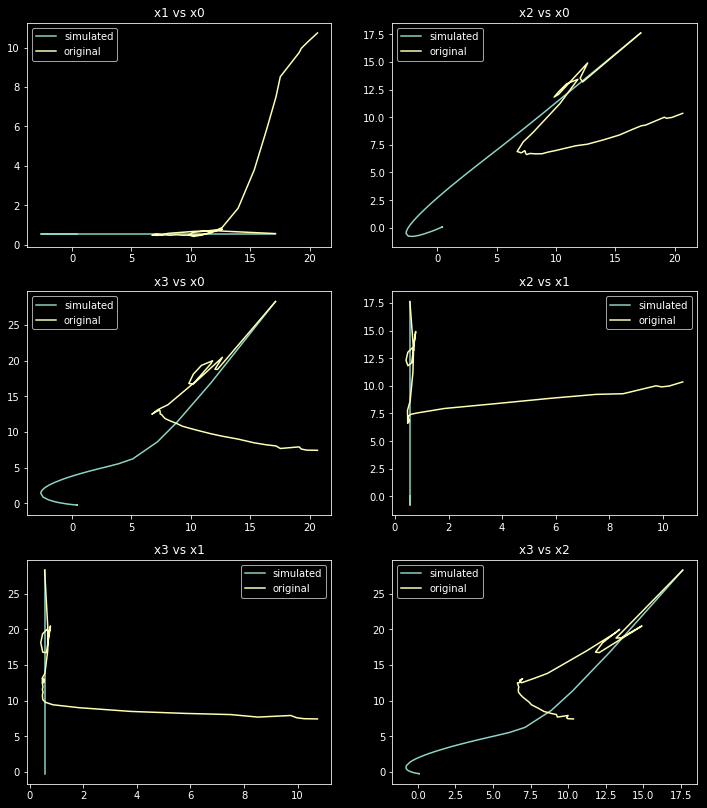

In [34]:
xa,xb = 0,2

combs = list(itertools.combinations(list(range(len(ixs))),2))
plt.figure(figsize=(12,14))
for k,(xa,xb) in enumerate(combs):
    ax = plt.subplot(int(len(combs)/2),2,k+1)
    ax.plot(X_s[:,xa],X_s[:,xb])
    ax.set_title('x{} vs x{}'.format(xb,xa))
    tXmat = tX.as_matrix()
    plt.plot(tXmat[:,xa],tXmat[:,xb])
    plt.legend(['simulated','original'])
plt.show()

###### Compare single var over time

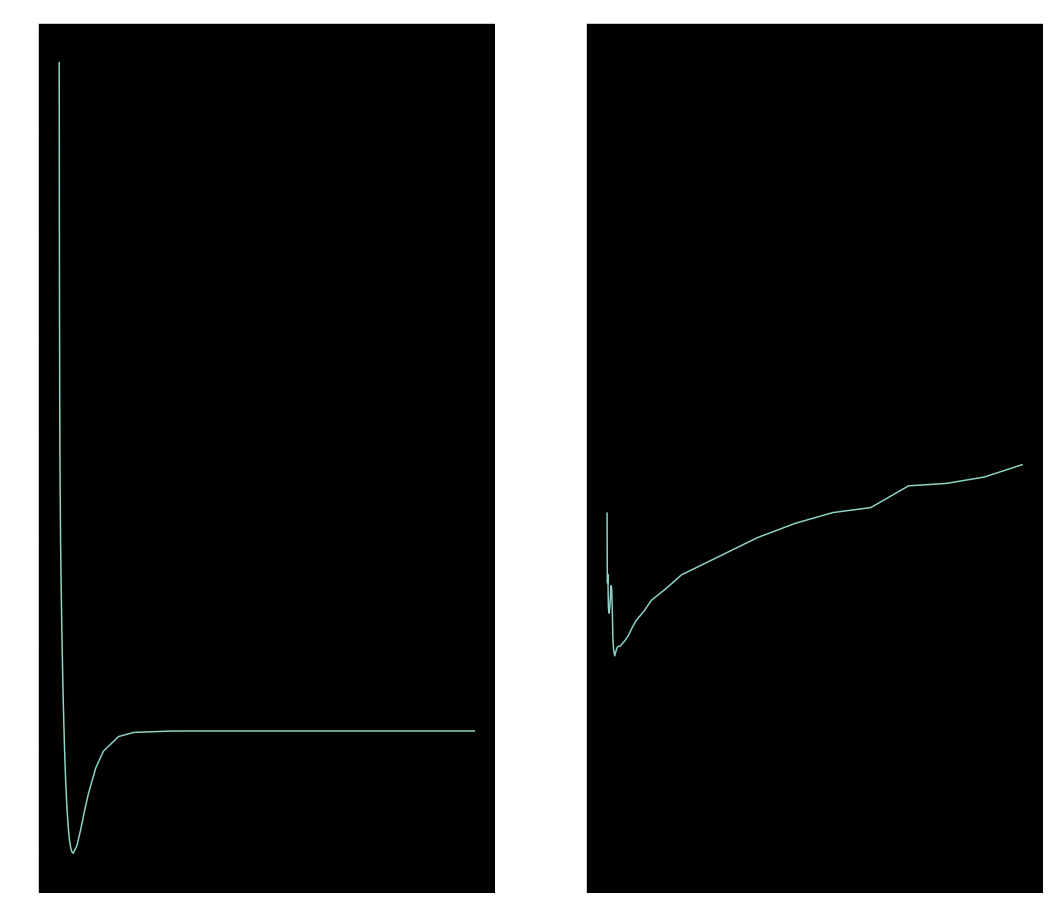

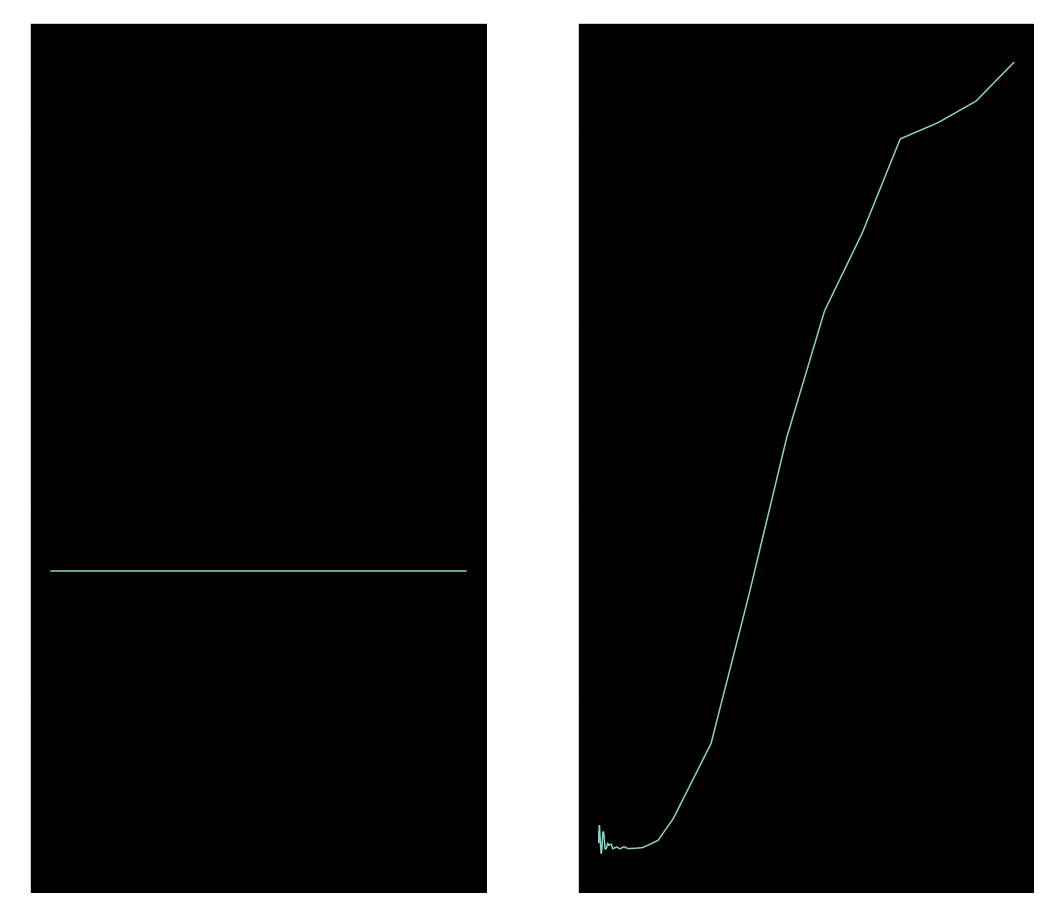

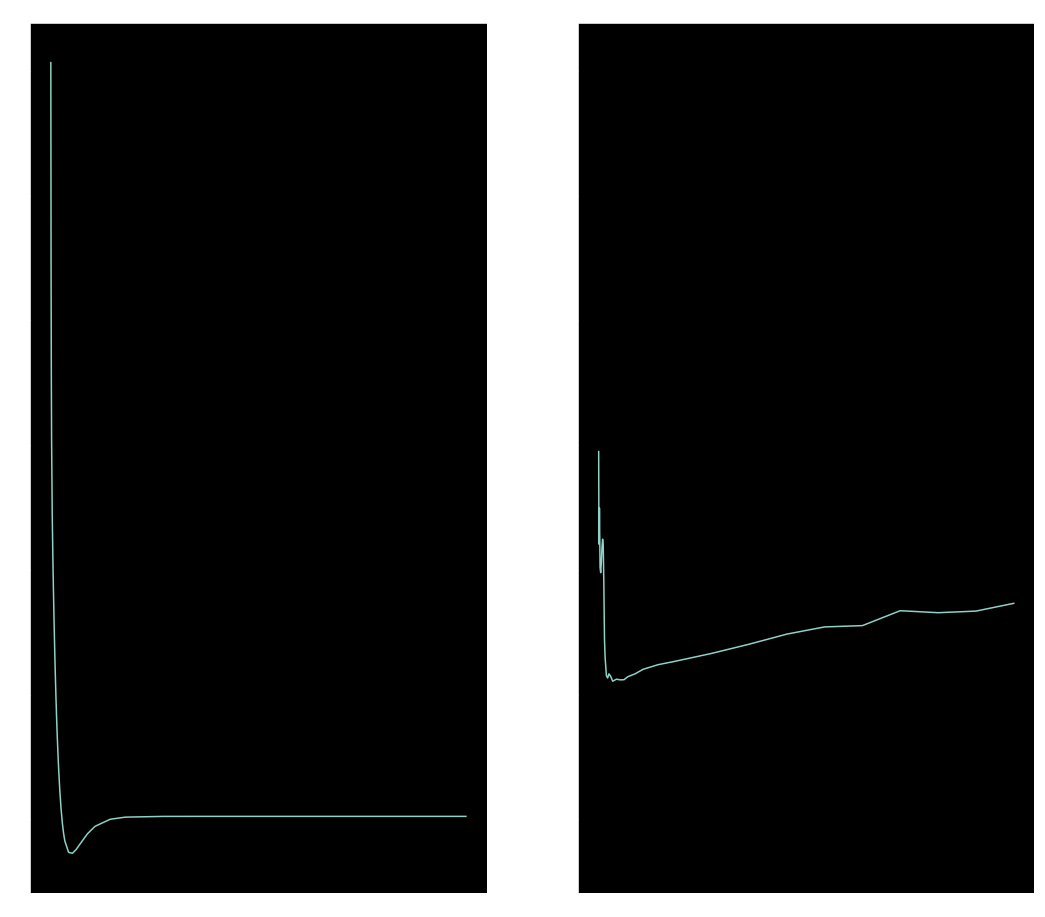

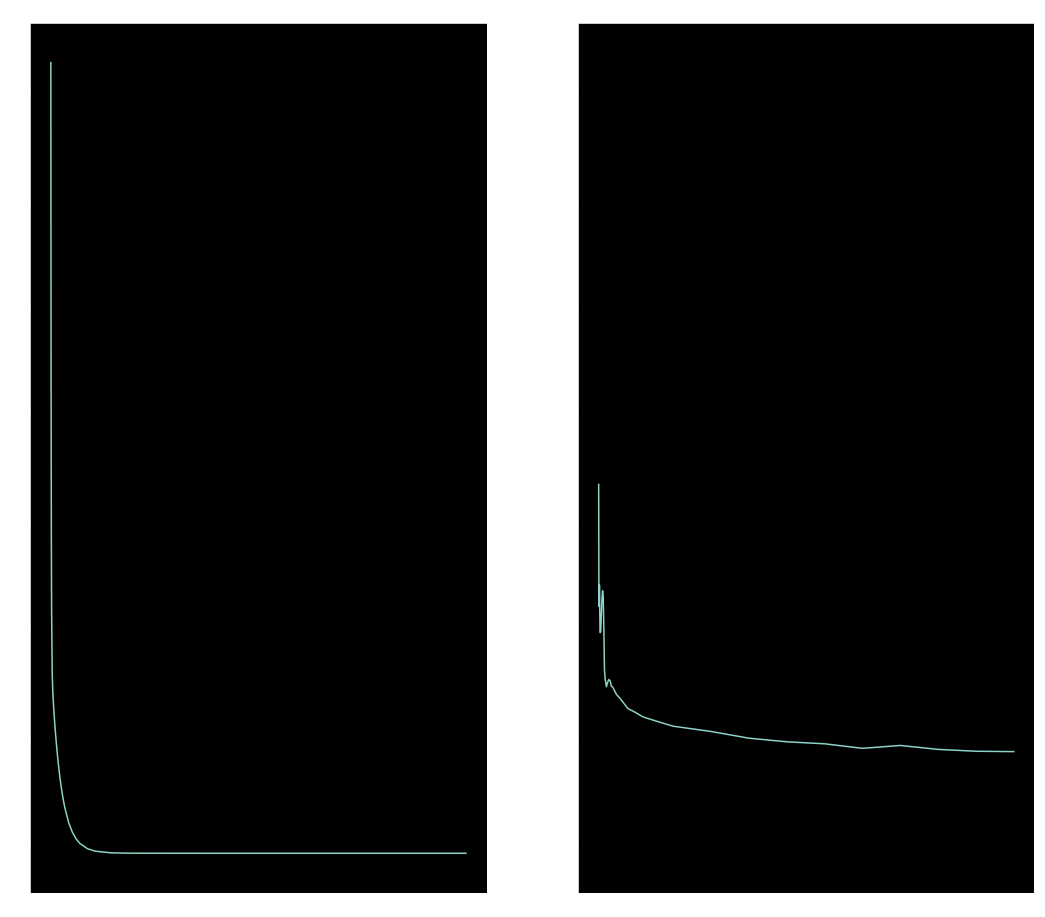

In [24]:
scale_trajectory = False

for x in range(len(ixs)):
    begin_off = 0

    fulldf = pd.concat([pd.DataFrame(X_s),tX],axis=1)

    plt.figure(figsize=(12, 8))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 16), sharey=True)
    sim_arr = X_s[begin_off:,x]
    orig_arr = tXmat[begin_off:,x]
    if scale_trajectory:
        sim_arr = sim_arr*(orig_arr.dot(sim_arr)/np.linalg.norm(sim_arr))
    
    ax1.plot(t_span[begin_off:],sim_arr/np.linalg.norm(sim_arr))
    ax2.plot(t_span[begin_off:],orig_arr/np.linalg.norm(orig_arr))
    ax1.set_title('simulated')
    ax2.set_title('original')
    plt.show()


#### Try modeling heart vs other clusters

         0        x1        x2
x1dot  0.0  0.996487  0.000000
x2dot  0.0  0.000000  0.999264


/Users/frankenstein/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


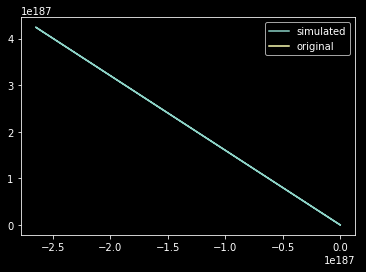

In [81]:
heart_ixs = [3,6,19]
noise_ixs = [0]
heart_df = df[heart_ixs]
body_df = df.drop(heart_ixs+noise_ixs,axis=1)

# body and heart into one df
X_df = pd.concat([heart_df.sum(axis=1),body_df.sum(axis=1)],axis=1)

# Xdot and select starting point
N = 40
n_start = 3
npts = N-n_start-1
tX = X_df[n_start:-1]
tX_dot = X_df.diff()[n_start+1:]

tX = tX.reset_index(drop=True)
tX = tX_dot.reset_index(drop=True)


# prep SINDy
n,nVars = tX.shape
cols = ['x{}'.format(i+1) for i in range(nVars)]
tX.columns = cols
dot_labels = pd.Index([s + 'dot' for s in cols])
polyorder = 1
lam = 0.001
usesine = 0
Theta = pd.DataFrame()
Theta = poolData(tX,nVars, polyorder, usesine)

# run SINDy
Xhat_df = sparsifyDynamics(Theta,tX_dot,lam)
Xhat_df = Xhat_df.set_index(dot_labels)
print(Xhat_df.head())

# test recovered dynamics
dynamic_fn = lambda x,t: np.squeeze(np.matmul(
        Xhat_df.as_matrix(),
        poolData(pd.DataFrame(x).T,nVars, polyorder, usesine).values.T
))
t_span = np.cumsum(frame_durations)
x0 = tX.iloc[0].values
dynamic_fn(x0,3)
X_s = odeint(dynamic_fn,x0,t_span)

# plot state space
xa,xb = 0,1
plt.plot(X_s[:,xa],X_s[:,xb])
tXmat = tX.as_matrix()
plt.plot(tXmat[:,xa],tXmat[:,xb])
plt.legend(['simulated','original'])
plt.show()



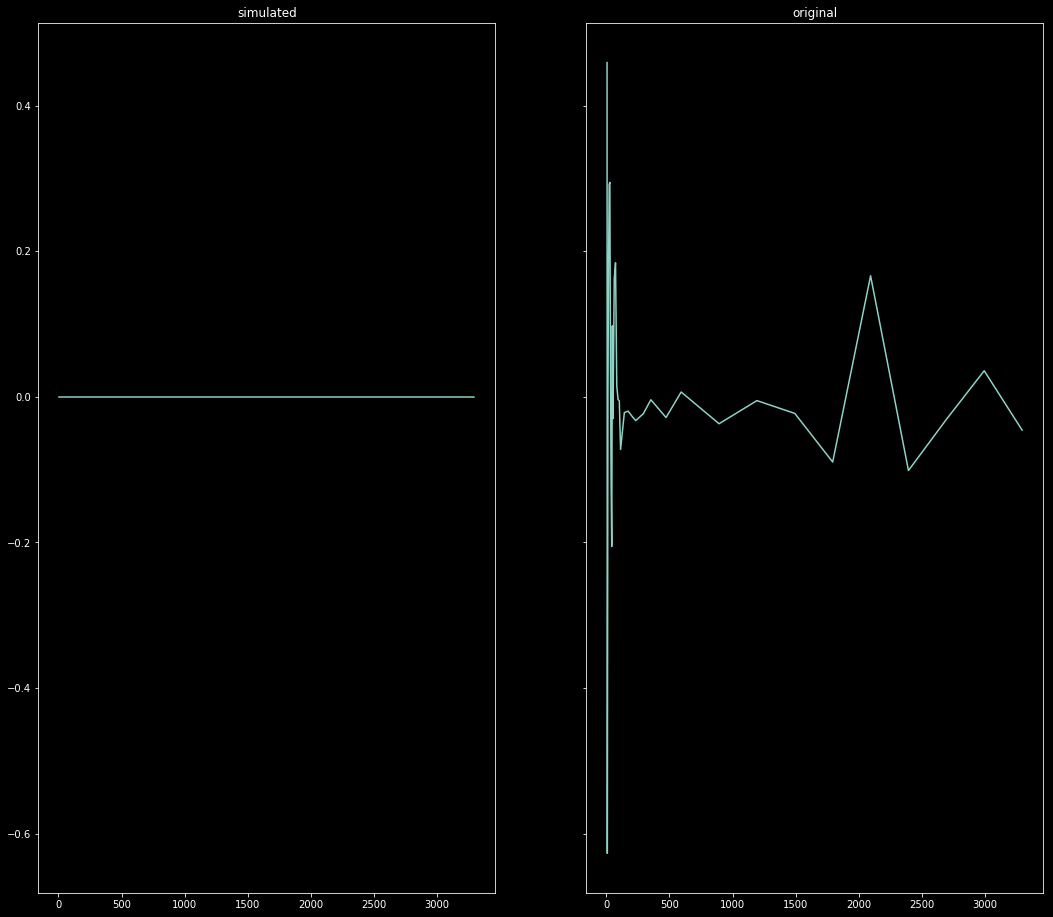

In [82]:
x = 1
begin_off = 2

fulldf = pd.concat([pd.DataFrame(X_s),tX],axis=1)

plt.figure(figsize=(12, 8))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 16), sharey=True)
sim_arr = X_s[begin_off:,x]
ax1.plot(t_span[begin_off:],sim_arr/np.linalg.norm(sim_arr))
orig_arr = tXmat[begin_off:,x]
ax2.plot(t_span[begin_off:],orig_arr/np.linalg.norm(orig_arr))
ax1.set_title('simulated')
ax2.set_title('original')
plt.show()

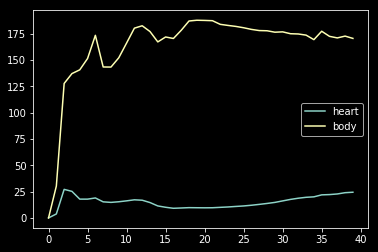

In [83]:
heart_df.sum(axis=1).plot()
body_df.sum(axis=1).plot()
plt.legend(['heart','body'])

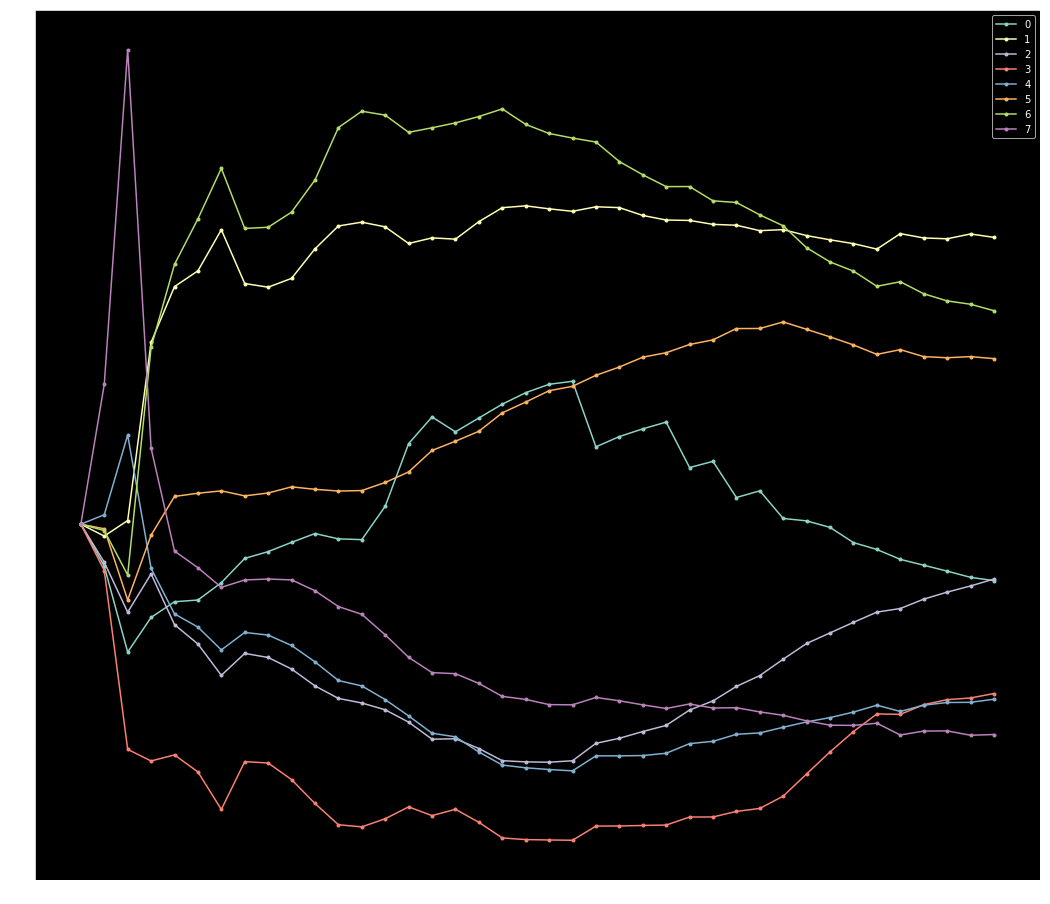

In [25]:
# subtract mean at each time point from corresponding intensities
sdf = df.subtract(df.mean(axis=1),axis=0)
sdf.plot(figsize=(18, 16),marker='.')